In [2]:
import numpy as np
import cv2
import glob
from os import path
from functions import *
from edge_detection import *
from matplotlib import pyplot as plt
from itertools import count

In [39]:
WORKING_FOLDER = 'data/calibration/david/20-04-2021'
INTRINSIC_PATH = 'data/calibration/david/intrinsic'
RAW_TARGET_OBJECT_IMAGE_NAME = 'frame_2021-04-18 16:50:52.088963.png'
RAW_CALIBRATING_OBJECT_IMAGE_NAME = 'frame_2021-04-18 16:51:45.830721.png'
CHESSBOARD_SQUARE_LENGTH_MM = 24
CHESSBOARD_DIMENSIONS = (9,6, CHESSBOARD_SQUARE_LENGTH_MM)
PLANE_CALIBRATION_OBJECT_HEIGHT_MM = 50
UNC_COMPONENTS_MASK_SIZE = 8

# Configure plt plot sizes for notebook
plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams['figure.dpi'] = 200

## Intrinsic parameter calibration

In [6]:
object_points, image_points, image_dimensions = chessboardPointExtraction(CHESSBOARD_DIMENSIONS,INTRINSIC_PATH)
ret, intrinsic_matrix, distortion_coefs, rotation_vecs, translation_vecs = cv2.calibrateCamera(object_points, image_points, image_dimensions,None,None)
print('\nImage Dimensions\n', image_dimensions)
print('\nIntrinsic Matrix\n', intrinsic_matrix)
print('\nDistortion Coefficients\n', distortion_coefs)
print(f'\nReprojection error: {calculateReprojectionError(object_points, image_points, rotation_vecs, translation_vecs, intrinsic_matrix, distortion_coefs)}')

100%|██████████| 20/20 [00:09<00:00,  2.16it/s]

Calibration over

Image Dimensions
 (1280, 720)

Intrinsic Matrix
 [[9.95501371e+02 0.00000000e+00 6.59362831e+02]
 [0.00000000e+00 1.00107125e+03 3.60433164e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion Coefficients
 [[ 0.27103847 -0.58181555 -0.02118469  0.00707566  0.56085949]]

Reprojection error: 0.04925399363823912


## Extrinsic parameter calibration

In [8]:
object_points, image_points, _ = chessboardPointExtraction(CHESSBOARD_DIMENSIONS, f'{WORKING_FOLDER}/extrinsic')
object_points_reshaped = np.array(object_points).reshape((-1,3))
image_points_reshaped = np.array(image_points).reshape((-1,2))

# Calculate extrinsic parameter matrices (translation and rotation) using PnP RANSAC
ret, rotation_vecs, translation_vecs, _ = cv2.solvePnPRansac(object_points_reshaped, image_points_reshaped, intrinsic_matrix, distortion_coefs)
print(f'Reprojection error: {calculateReprojectionError(object_points, image_points, rotation_vecs, translation_vecs, intrinsic_matrix, distortion_coefs)}')

100%|██████████| 20/20 [00:01<00:00, 10.39it/s]
Calibration over
Reprojection error: 0.1230894855487579



## Projection Calculation

In [10]:
perspective_projection_matrix = calculatePpmMatrix(intrinsic_matrix, rotation_vecs, translation_vecs)

## Shadow/Light Plane Calibration

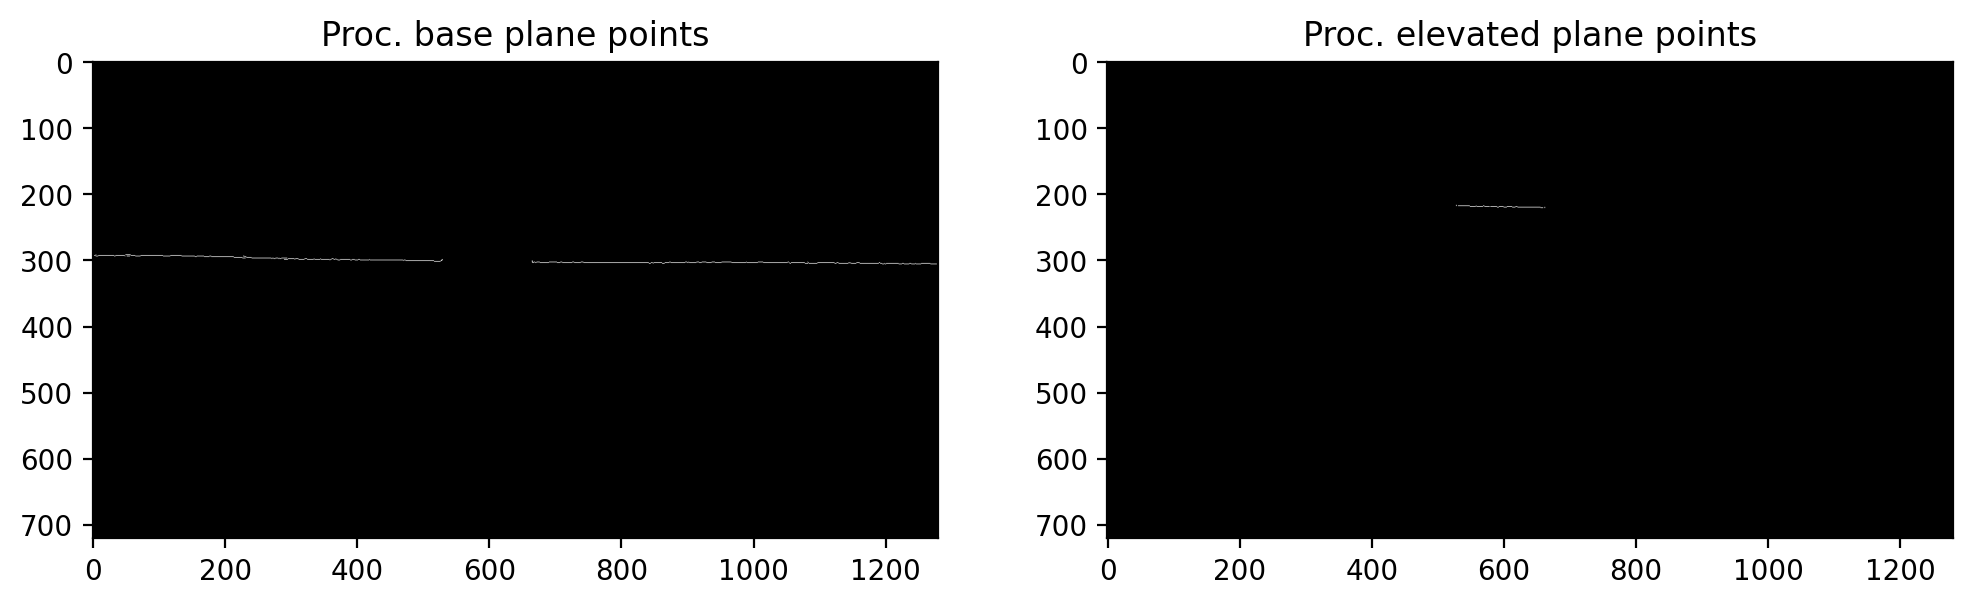

In [12]:

plane_calib_img_raw = cv2.imread(f'{WORKING_FOLDER}/{RAW_CALIBRATING_OBJECT_IMAGE_NAME}',cv2.IMREAD_GRAYSCALE)

# Extract shadow points from raw image (shadow points in white)
plane_calib_img_processed = extract_shadow_points_auto(plane_calib_img_raw)['result']

# Split the bottom plane shadow and the top plane shadow
processed_base_plane_points, processed_elevated_plane_points = splitTopBottomPoints(plane_calib_img_processed)

fig, subplots = plt.subplots(1,2)
subplots[0].set_title('Proc. base plane points')
subplots[0].imshow(processed_base_plane_points, cmap='gray' , vmin=0, vmax=255)

subplots[1].set_title('Proc. elevated plane points')
subplots[1].imshow(processed_elevated_plane_points, cmap='gray', vmin=0, vmax=255)

In [14]:
# 'Floor' points
floor_plane_constraint = [0,0,1,0] # z=0
base_points = getWhitePoint3DCoords(processed_base_plane_points, [floor_plane_constraint], perspective_projection_matrix)

# Object top points
elevated_plane_constraint = [0,0,1,PLANE_CALIBRATION_OBJECT_HEIGHT_MM]
elevated_points = getWhitePoint3DCoords(processed_elevated_plane_points, [elevated_plane_constraint], perspective_projection_matrix)

plane_3d_points = list(base_points)
plane_3d_points.extend(elevated_points)

In [16]:
# Calculate plane coeficients
plane_coefs = calculatePlaneCoefs(np.array(plane_3d_points))
plane_coefs

[-55.561440232904786, -0.007119754585813174, -1.0, 34.232670533211454]

## Target object point extraction

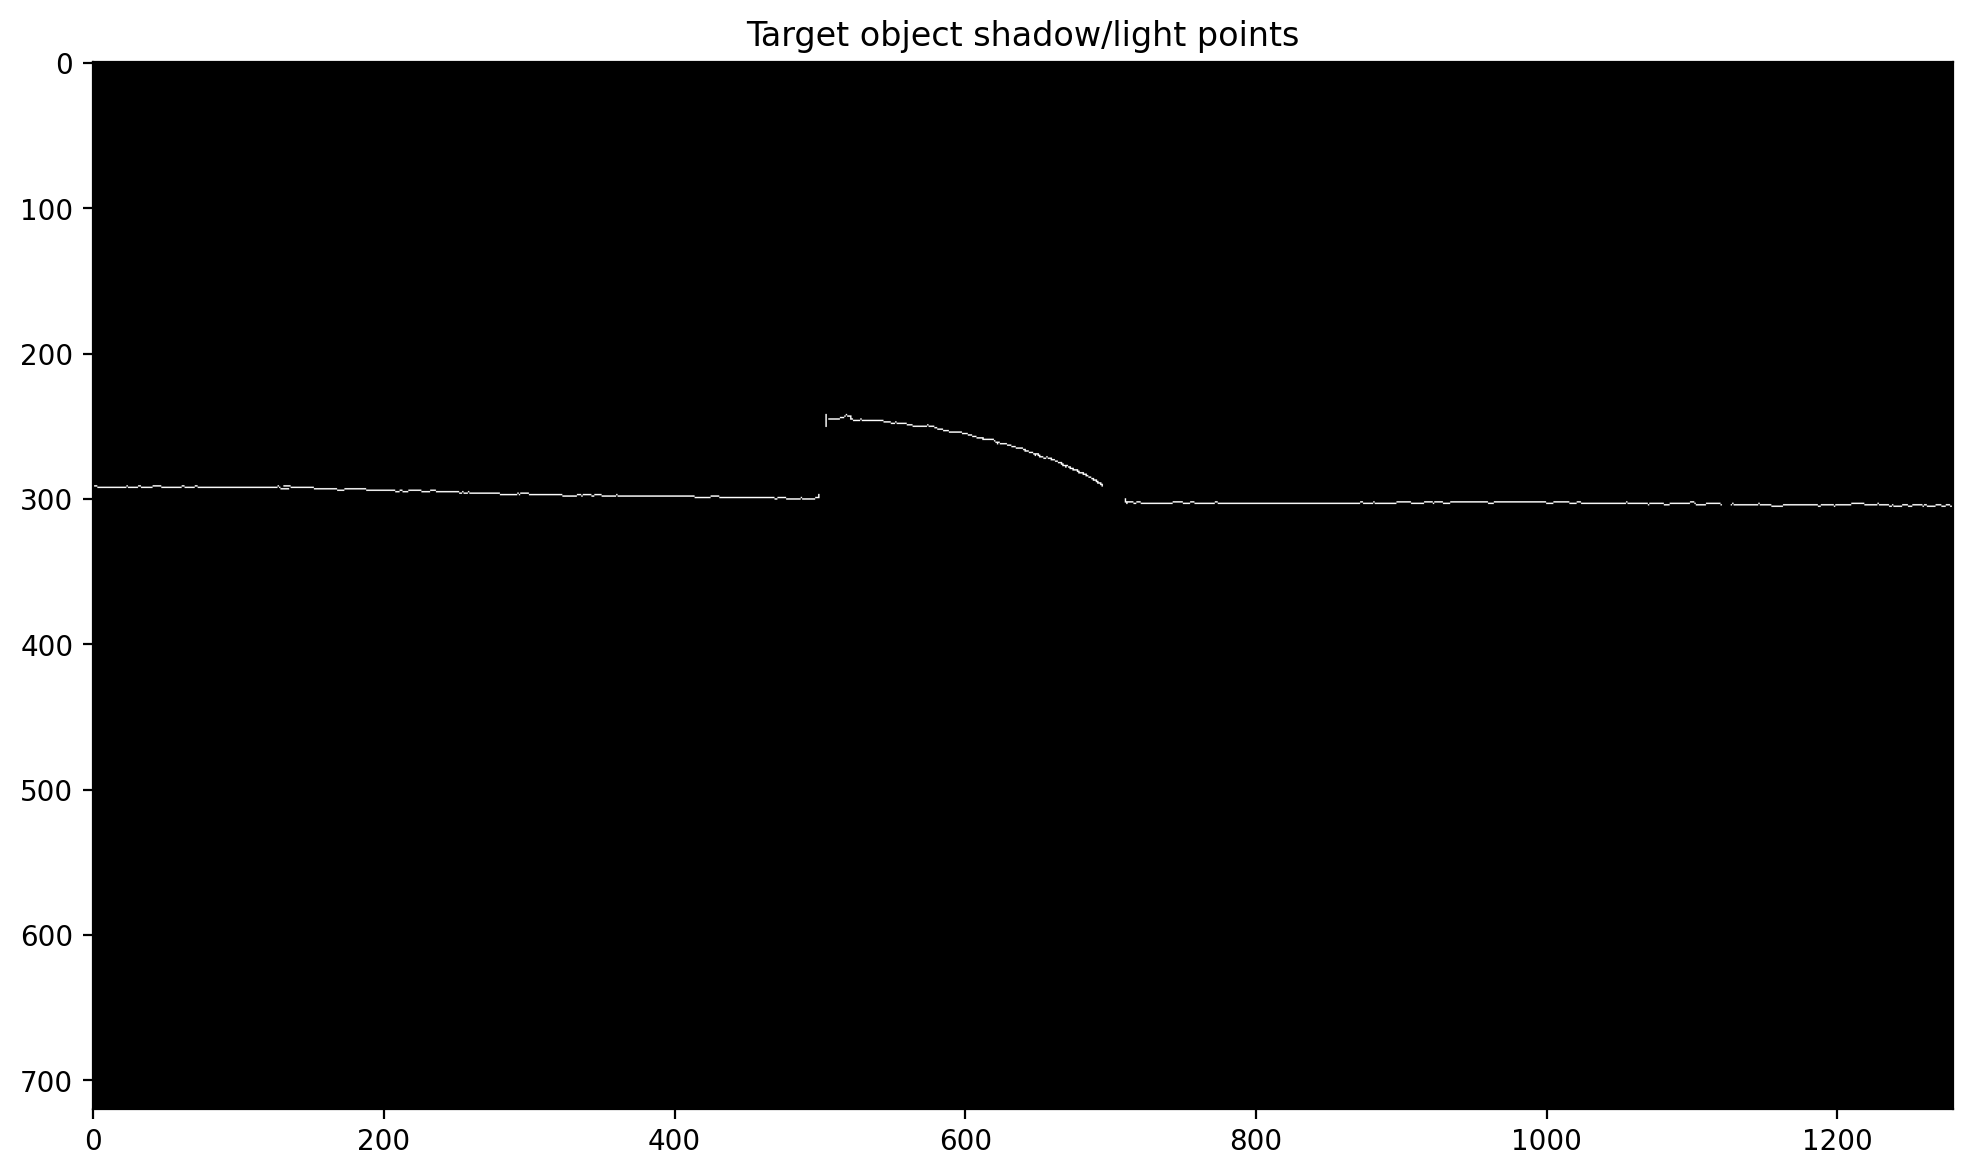

In [18]:
target_object_points_raw = cv2.imread(f'{WORKING_FOLDER}/{RAW_TARGET_OBJECT_IMAGE_NAME}')
target_object_points_raw_gray = cv2.cvtColor(target_object_points_raw, cv2.COLOR_BGR2GRAY)

# Detect shadow line
target_object_points_processed = extract_shadow_points_auto(target_object_points_raw_gray)['result']

# Remove unconnected components from processed image (aimed at removing some of the noise)
target_object_points_processed = remove_unconnected_points(target_object_points_processed, UNC_COMPONENTS_MASK_SIZE)

plt.title('Target object shadow/light points')
plt.imshow(target_object_points_processed, cmap='gray')

In [20]:
# Calculate y and z for points in shadow
points = getWhitePoint3DCoords(target_object_points_processed, [plane_coefs], perspective_projection_matrix)

points_x = [point[0] for point in points]
points_y = [point[1] for point in points]
points_z = [point[2] for point in points]


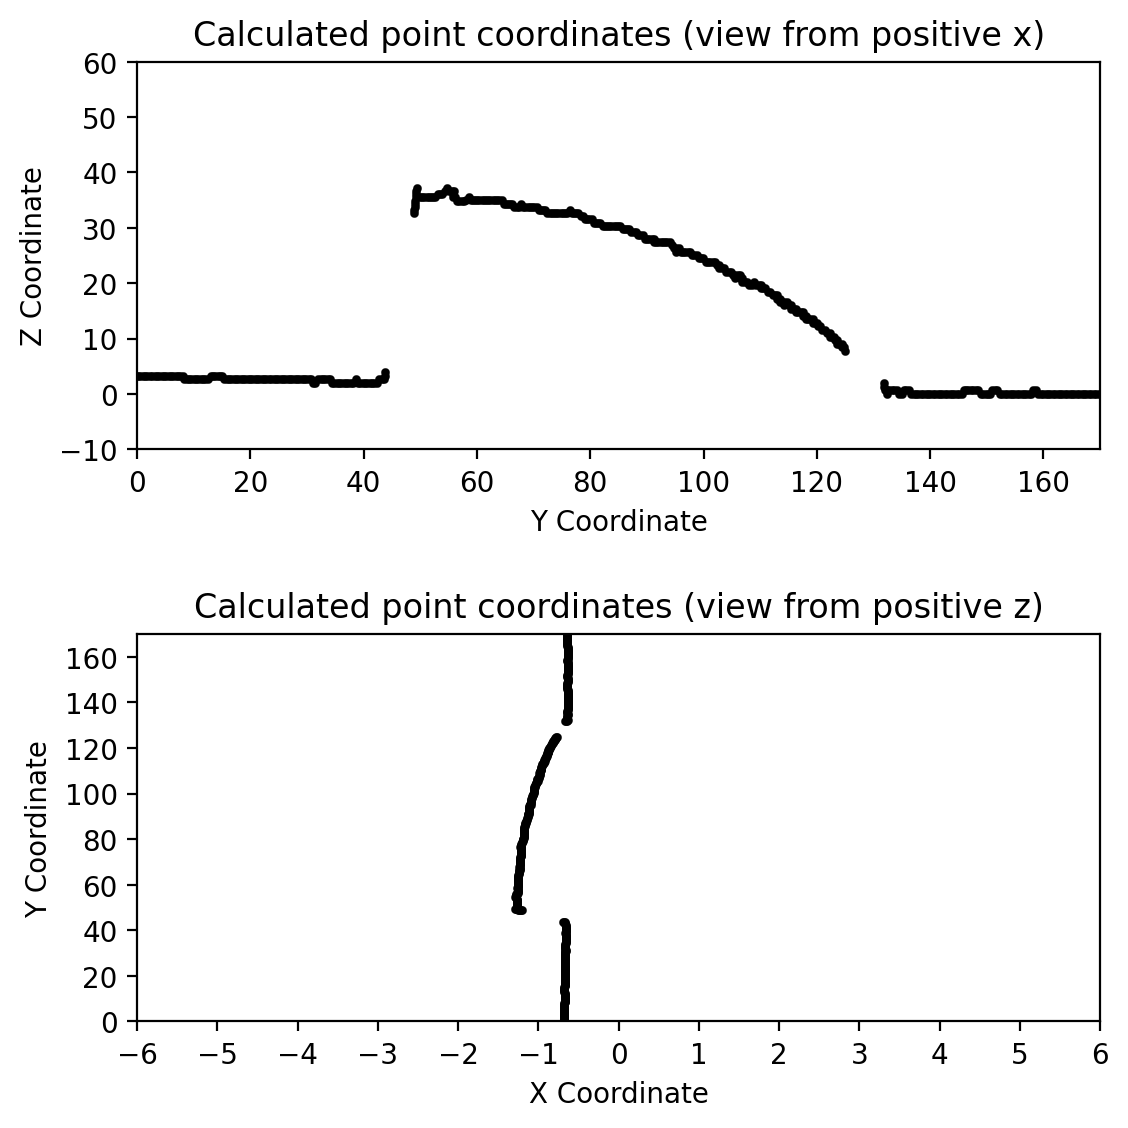

In [46]:
figure, subplots = plt.subplots(2)
subplots[0].set_title('Calculated point coordinates (view from positive x)')
subplots[0].set_xlabel('Y Coordinate')
subplots[0].set_ylabel('Z Coordinate')
subplots[0].set_xlim([0,170])
subplots[0].set_ylim([-10,60])
subplots[0].set_xticks(np.arange(0, 180, 20))
subplots[0].set_yticks(np.arange(-10, 70, 10))
subplots[0].scatter(points_y, points_z, color='black', marker='.', linewidths=0.1)

subplots[1].set_title('Calculated point coordinates (view from positive z)')
subplots[1].set_xlabel('X Coordinate')
subplots[1].set_ylabel('Y Coordinate')
subplots[1].set_xlim([-6,6])
subplots[1].set_ylim([0,170])
subplots[1].set_xticks(np.arange(-6, 7, 1))
subplots[1].set_yticks(np.arange(0, 180, 20))
subplots[1].scatter(points_x, points_y, color='black', marker='.', linewidths=0.1)
figure.tight_layout(pad=2)
plt.savefig('test.png')